In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [2]:
import re

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from keras import backend as K
from keras.models import Model
from keras import initializers
from keras.engine.topology import Layer
from keras.layers import Dense, Input
from keras.layers import Embedding, GRU, Bidirectional, TimeDistributed
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical
from nltk import tokenize
import jieba

from tqdm import tqdm

Using TensorFlow backend.


In [3]:
maxlen = 50
max_sentences = 50
max_words = 20000
embedding_dim = 100
validation_split = 0.2
reviews = []
labels = []
texts = []
glove_dir = "./"
embeddings_index = {}


In [4]:
# class defining the custom attention layer
class HierarchicalAttentionNetwork(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(HierarchicalAttentionNetwork, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim,)))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(HierarchicalAttentionNetwork, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]
    
    def _get_attention_weights(self, X):

        uit = K.tanh(K.bias_add(K.dot(X, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        return ait

In [5]:
def remove_html(str_a):
    p = re.compile(r'<.*?>')
    return p.sub('', str_a)


# replace all non-ASCII (\x00-\x7F) characters with a space
def replace_non_ascii(str_a):
    return re.sub(r'[^\x00-\x7f]', r'', str_a)


# Tokenization/string cleaning for dataset
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()


import re

def cut_sent(para):
    para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 单字符断句符
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略号
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略号
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    # 如果双引号前有终止符，那么双引号才是句子的终点，把分句符\n放到双引号后，注意前面的几句都小心保留了双引号
    para = para.rstrip()  # 段尾如果有多余的\n就去掉它
    # 很多规则中会考虑分号;，但是这里我把它忽略不计，破折号、英文双引号等同样忽略，需要的再做些简单调整即可。
    final_splits = [_ for _ in para.split("\n") if _]
    return final_splits

In [9]:
input_data = pd.read_csv('thucnews_all.csv').sample(20000)

In [90]:
input_data.label.value_counts()

8     3954
4     3701
11    3102
12    2228
7     1540
3     1237
5     1019
6      865
9      758
2      559
1      467
10     309
0      185
13      76
Name: label, dtype: int64

In [11]:
input_data.shape

(20000, 2)

In [15]:
# input_data.index

In [14]:
for idx in tqdm(input_data.index):
    text = ' '.join(jieba.lcut(input_data.text[idx]))
    texts.append(text)
    sentences = cut_sent(text)
    reviews.append(sentences)
    labels.append(input_data.label[idx])

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

  0%|          | 0/20000 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.851 seconds.
Prefix dict has been built successfully.
100%|██████████| 20000/20000 [01:29<00:00, 223.23it/s]


In [17]:
sentences[0]

'高画质 逐行 扫面   松下 TM700 促销价 6800 元   作者 ： 李金昊   北京 行情   松下 TM700 是 一款 拥有 3MOS 感光 元件 的 高清 双模 存储 数码 摄像机 产品 。'

In [16]:
data = np.zeros((len(texts), max_sentences, maxlen), dtype='int32')

for i, sentences in tqdm(enumerate(reviews)):
    for j, sent in enumerate(sentences):
        if j < max_sentences:
            wordTokens = [_ for _ in sent.split() if _.strip()]
            k = 0
            for _, word in enumerate(wordTokens):
                if word not in tokenizer.word_index:
                    continue
                if k < maxlen and tokenizer.word_index[word] < max_words:
                    data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

20000it [01:49, 182.82it/s]

Total 228844 unique tokens.


In [18]:
labels = to_categorical(np.asarray(labels))
print('Shape of reviews (data) tensor:', data.shape)
print('Shape of sentiment (label) tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(validation_split * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Number of positive and negative reviews in training and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))


Shape of reviews (data) tensor: (20000, 50, 50)
Shape of sentiment (label) tensor: (20000, 14)
Number of positive and negative reviews in training and validation set
[ 146.  367.  448.  999. 2938.  800.  696. 1239. 3147.  615.  248. 2508.
 1789.   60.]
[ 39. 100. 111. 238. 763. 219. 169. 301. 807. 143.  61. 594. 439.  16.]


In [ ]:
# f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print('Total %s word vectors.' % len(embeddings_index))

In [19]:
# building Hierachical Attention network
# embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1, embedding_dim,
                            input_length=maxlen, trainable=True, mask_zero=True)

In [21]:
# type(sentenceEncoder)

In [30]:
sentence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_word = Bidirectional(GRU(25, return_sequences=True))(embedded_sequences)
attn_word = HierarchicalAttentionNetwork(20)(lstm_word)
sentenceEncoder = Model(sentence_input, attn_word)

review_input = Input(shape=(max_sentences, maxlen), dtype='int32')
review_encoder = TimeDistributed(sentenceEncoder)(review_input)
lstm_sentence = Bidirectional(GRU(25, return_sequences=True))(review_encoder)
attn_sentence = HierarchicalAttentionNetwork(20)(lstm_sentence)
preds = Dense(y_train.shape[1], activation='softmax')(attn_sentence)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [31]:
sentenceEncoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 100)           22884500  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 50)            18900     
_________________________________________________________________
hierarchical_attention_netwo (None, 50)                1040      
Total params: 22,904,440
Trainable params: 22,904,440
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 50, 50)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 50)            22904440  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 50)            11400     
_________________________________________________________________
hierarchical_attention_netwo (None, 50)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 14)                714       
Total params: 22,917,594
Trainable params: 22,917,594
Non-trainable params: 0
_________________________________________________________________


In [34]:
print("model fitting - Hierachical attention network")
model.fit(x_train, y_train, validation_data=(x_val, y_val), nb_epoch=5, batch_size=100)

model fitting - Hierachical attention network
Train on 16000 samples, validate on 4000 samples
Epoch 1/5


/data/bigData/wangke/atten_ocr_venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


16000/16000 [==============================] - 35s 2ms/step - loss: 0.6888 - acc: 0.7871 - val_loss: 0.5816 - val_acc: 0.8275
Epoch 2/5
16000/16000 [==============================] - 34s 2ms/step - loss: 0.3436 - acc: 0.9041 - val_loss: 0.5007 - val_acc: 0.8600
Epoch 3/5
16000/16000 [==============================] - 35s 2ms/step - loss: 0.1873 - acc: 0.9539 - val_loss: 0.4831 - val_acc: 0.8732
Epoch 4/5
16000/16000 [==============================] - 43s 3ms/step - loss: 0.1026 - acc: 0.9803 - val_loss: 0.5008 - val_acc: 0.8712
Epoch 5/5
16000/16000 [==============================] - 54s 3ms/step - loss: 0.0623 - acc: 0.9875 - val_loss: 0.5168 - val_acc: 0.8742


In [36]:
np.argmax(model.predict(data[:1])), np.argmax(labels[:1])

(7, 7)

In [37]:
def text2data(text):
    text = ' '.join(jieba.lcut(text))
    sentences = cut_sent(text)
    _reviews = [sentences]
    test_data = np.zeros((1, max_sentences, maxlen), dtype='int32')

    for i, sentences in enumerate(_reviews):
        for j, sent in enumerate(sentences):
            if j < max_sentences:
                wordTokens = [_ for _ in jieba.lcut(sent.replace(' ', '')) if _.strip()]
                k = 0
                for _, word in enumerate(wordTokens):
                    if word not in tokenizer.word_index:
                        continue
                    if k < maxlen and tokenizer.word_index[word] < max_words:
                        test_data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1
    return test_data, sentences

In [39]:
cls2idx = {'体育': 11,
 '娱乐': 12,
 '家居': 9,
 '彩票': 0,
 '房产': 1,
 '教育': 5,
 '时尚': 10,
 '时政': 7,
 '星座': 13,
 '游戏': 2,
 '社会': 3,
 '科技': 8,
 '股票': 4,
 '财经': 6}
cls2idx

idx2cls = {i:c for c, i in cls2idx.items()}
idx2cls

{0: '彩票',
 1: '房产',
 2: '游戏',
 3: '社会',
 4: '股票',
 5: '教育',
 6: '财经',
 7: '时政',
 8: '科技',
 9: '家居',
 10: '时尚',
 11: '体育',
 12: '娱乐',
 13: '星座'}

In [108]:
testvec, testsents = text2data("""
据路透社报道，美国国家科技政策办公室周一要求研究人员使用人工智能技术分析约2.9万篇学术论文，以回答有关新冠病毒的关键问题。

白宫设立的这个办公室表示，已与微软和谷歌等公司合作，编纂了可供研究人员使用的有关新冠病毒的最广泛的学术论文数据库。

世界卫生组织(WHO)和美国疾病控制和预防中心(CDC)表示，他们希望为更好地了解新冠病毒的起源和传播提供帮助，以协助开发疫苗和治疗方法。

在白宫工作的美国首席技术官Michael Kratsios在一次电话会议上告诉记者，他们希望计算机能够比人类更快地扫描研究结果，并发现人类可能错过的发现。

报道指出，机器学习(Machine learning)是人工智能的一种形式，其软件被设计用于自行检测数据中的模式，目前已被医疗保健和其他行业用于从大量文本中开发摘要。但在它能够有效地得出结论之前，有时需要分析数百万个类似的内容。

""")
cls_int = np.argmax(model.predict(testvec))
print('Label: ', idx2cls[cls_int])

Label:  科技


In [46]:
import matplotlib.pyplot as plt

In [58]:
y_pred = model.predict(x_val, verbose=1)

4000/4000 [==============================] - 5s 1ms/step


In [60]:
y_pred = [np.argmax(_) for _ in y_pred]

In [62]:
from sklearn.metrics import confusion_matrix

In [72]:
labels=idx2cls.values()
idx2cls.values()

dict_values(['彩票', '房产', '游戏', '社会', '股票', '教育', '财经', '时政', '科技', '家居', '时尚', '体育', '娱乐', '星座'])

In [75]:
pred_cm = confusion_matrix(np.array([np.argmax(_) for _ in y_val]), np.array(y_pred))

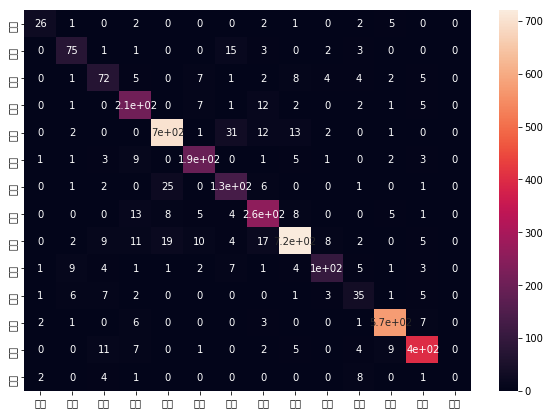

In [77]:
import seaborn as sn

df_cm = pd.DataFrame(pred_cm, index = [i for i in idx2cls.values()],
                  columns = [i for i in idx2cls.values()])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [78]:
from sklearn.metrics import classification_report

In [84]:
from pprint import pprint

In [89]:
print(classification_report([np.argmax(_) for _ in y_val], y_pred, target_names=[_ for _ in idx2cls.values()]))

              precision    recall  f1-score   support

          彩票       0.79      0.67      0.72        39
          房产       0.75      0.75      0.75       100
          游戏       0.64      0.65      0.64       111
          社会       0.78      0.87      0.82       238
          股票       0.93      0.92      0.92       763
          教育       0.85      0.88      0.87       219
          财经       0.68      0.79      0.73       169
          时政       0.81      0.85      0.83       301
          科技       0.94      0.89      0.91       807
          家居       0.84      0.73      0.78       143
          时尚       0.52      0.57      0.55        61
          体育       0.96      0.97      0.96       594
          娱乐       0.92      0.91      0.91       439
          星座       0.00      0.00      0.00        16

    accuracy                           0.87      4000
   macro avg       0.74      0.75      0.74      4000
weighted avg       0.87      0.87      0.87      4000



In [94]:
print(classification_report([np.argmax(_) for _ in y_val], y_pred))

              precision    recall  f1-score   support

           0       0.79      0.67      0.72        39
           1       0.75      0.75      0.75       100
           2       0.64      0.65      0.64       111
           3       0.78      0.87      0.82       238
           4       0.93      0.92      0.92       763
           5       0.85      0.88      0.87       219
           6       0.68      0.79      0.73       169
           7       0.81      0.85      0.83       301
           8       0.94      0.89      0.91       807
           9       0.84      0.73      0.78       143
          10       0.52      0.57      0.55        61
          11       0.96      0.97      0.96       594
          12       0.92      0.91      0.91       439
          13       0.00      0.00      0.00        16

    accuracy                           0.87      4000
   macro avg       0.74      0.75      0.74      4000
weighted avg       0.87      0.87      0.87      4000



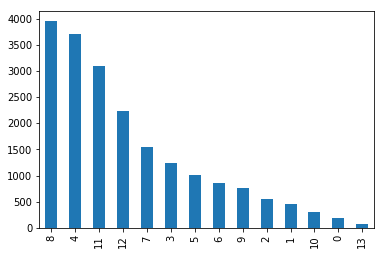

In [93]:
input_data.label.value_counts().plot(kind='bar')